In [10]:
# from app import app, db#, cache

from matplotlib.mlab import griddata
import matplotlib.pyplot as plt

import time, os
from collections import defaultdict

import numpy as np
from numpy import linspace
from numpy import meshgrid
from numpy.random import uniform, seed

from mpl_toolkits.basemap import Basemap, shiftgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

title_sz = 27
axis_sz = 22
tick_sz = 21

from matplotlib.ticker import MaxNLocator
from matplotlib import cm, rcParams
rcParams.update({'font.size': tick_sz-4}) # Increase font-size
# from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm
from matplotlib import gridspec

import pylab as pl

from itertools import islice
import sys, pickle, time, copy, re

from chem_ocean import Build_Map as bm

import sqlalchemy

import pandas as pd

In [146]:
from sklearn.cluster import MiniBatchKMeans as mkm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [2]:
def connect(user, password, db, host='localhost', port=5432):
    '''Returns a connection and a metadata object'''
    url  = 'postgresql://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)

    # The return value of create_engine() is our connection object
    con = sqlalchemy.create_engine(url, client_encoding='utf8')

    # We then bind the connection to MetaData()
    meta = sqlalchemy.MetaData(bind=con, reflect=True)

    return con, meta, url

In [3]:
conn, meta, url = connect('jlanders', '', 'odv_app_dev', host='localhost', port=5432)

/usr/local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SADeprecationWarning: reflect=True is deprecate; please use the reflect() method.
  # Remove the CWD from sys.path while we load stuff.


In [111]:
minLat = -55
maxLat = 60
minLon = -180
maxLon = 180

In [112]:
# Helper function to query DataFrame for slice of interest
def dfQueryFunc(minLat, maxLat, minLon, maxLon, _var_names,**kwargs):
    basic = ['station', 'longitude', 'latitude']
    
    if 'Depth' in kwargs:
        sum_names = basic +_var_names
    else: 
        sum_names = basic + ['depth'] + _var_names

    print(sum_names)
    cols = ', '.join(sum_names)

    if 'Latitude' in kwargs:
        lat_target = kwargs['Latitude']
        minLat = lat_target-1.5
        maxLat = lat_target+1.5
        (lonMin, lonMax) = kwargs['lonLimits']
        # _var_df = _df3_sub[sum_names].query('Latitude >= '+str(lat_target-3)+ 'and Latitude <= '+str(lat_target+3)+ ' and Longitude >= '+str(lonMin)+ 'and Longitude <= '+str(lonMax))
    if 'Longitude' in kwargs:
        lon_target = kwargs['Longitude']
        minLon = lon_target-1.5
        maxLon = lon_target+1.5
        (latMin, latMax) = kwargs['latLimits']
        # _var_df = _df3_sub[sum_names].query('Longitude >= '+str(lon_target-3)+ 'and Longitude <= '+str(lon_target+3) +' and Latitude >= '+str(latMin)+ 'and Latitude <= '+str(latMax))
    query = "select "+ cols+ " from woa13 where latitude> {} AND latitude< {} AND longitude>{} and longitude<{};".format(str(minLat), str(maxLat), str(minLon), str(maxLon))
    
    if 'Depth' in kwargs:
        depth_target = kwargs['Depth']
        query = "select "+ cols+ " from woa13 where latitude> {} AND latitude< {} AND longitude>{} and longitude<{} and depth={};".format(str(minLat), str(maxLat), str(minLon), str(maxLon), str(depth_target))
    print(query)
    return query, sum_names#_var_df

In [172]:
tracers = ['salinity', 'oxygen', 'nitrate', 'temperature']
query, sum_names = dfQueryFunc(minLat, maxLat, minLon, maxLon, tracers, Depth=1500)

['station', 'longitude', 'latitude', 'salinity', 'oxygen', 'nitrate', 'temperature']
select station, longitude, latitude, salinity, oxygen, nitrate, temperature from woa13 where latitude> -55 AND latitude< 60 AND longitude>-180 and longitude<180 and depth=1500;


In [173]:
result = conn.execute(query)

In [174]:
data_array = []
for row in result:
    data_array.append(list(row))
df = pd.DataFrame(data_array)

df.columns = sum_names
df.dropna()

lat_scale = StandardScaler()
lat_scale.fit(df[['latitude']].as_matrix())
df['s_latitude'] = lat_scale.transform(df[['latitude']])

lon_scale = StandardScaler()
lon_scale.fit(df[['longitude']].as_matrix())
df['s_longitude'] = lon_scale.transform(df[['longitude']])

for tracer in tracers:
    df[tracer].round(decimals = 3)
    
    scale = StandardScaler()

    df[[tracer]] = scale.fit_transform(df[[tracer]].as_matrix())

df.describe()

,longitude,latitude,salinity,oxygen,nitrate,temperature,s_latitude,s_longitude
count,26361.000000,26361.000000,2.636100e+04,2.636100e+04,2.636100e+04,2.636100e+04,2.636100e+04,2.636100e+04
mean,-14.016217,-7.010944,-2.577911e-15,-1.983838e-16,3.795168e-16,-4.808650e-16,-1.725076e-17,-2.156345e-18
std,111.438920,30.964058,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00
min,-179.500000,-54.500000,-2.444244e+01,-2.257720e+00,-4.594790e+00,-2.760163e+00,-1.533712e+00,-1.485001e+00
25%,-118.500000,-34.500000,-2.362516e-01,-8.329838e-01,-3.065452e-01,-4.126793e-01,-8.877899e-01,-9.376057e-01
50%,-25.500000,-9.500000,-1.524248e-01,1.408474e-01,1.524210e-01,-2.182675e-01,-8.038685e-02,-1.030520e-01
75%,83.500000,17.500000,9.648754e-02,7.312365e-01,7.339001e-01,2.275435e-01,7.916084e-01,8.750809e-01
max,179.500000,59.500000,8.061613e+00,2.396203e+00,1.977760e+00,9.611661e+00,2.148046e+00,1.736556e+00


0.34735774993896484


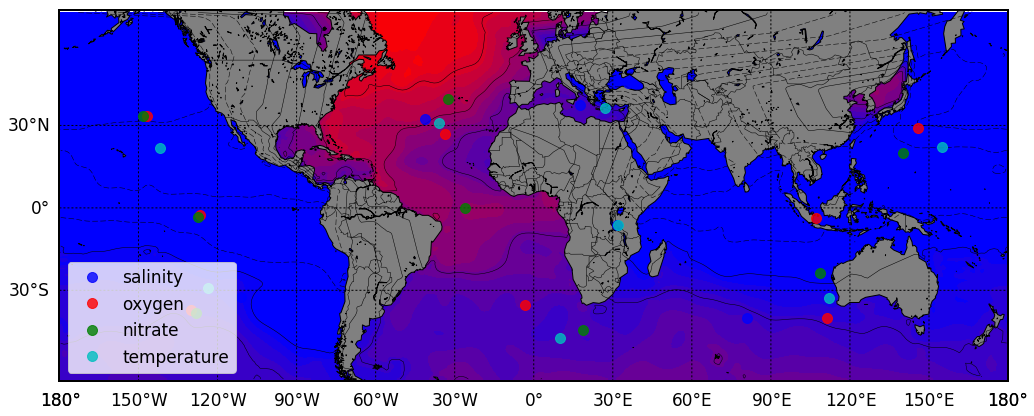

In [180]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17, 17), facecolor='w')
_basemap, fig, ax = bm.build_map('y', 'merc', minLat, maxLat, minLon, maxLon, 'c', fig, ax, 111, 'lb')

colors = ['bo', 'ro', 'go', 'co']
for ik, tracer in enumerate(tracers):
    data = df[['s_longitude', 's_latitude', tracer]].values
    kmeans = km(n_clusters=8, random_state=0).fit(data)
    centers = kmeans.cluster_centers_
    for center in centers:
        x,y = _basemap(lon_scale.inverse_transform([center[0]]), lat_scale.inverse_transform([center[1]]))
        ax.plot(x, y, colors[ik], markersize=10, alpha = .8, label = tracer)

        
from collections import OrderedDict
import matplotlib.pyplot as plt

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc = 3)

_x = df['longitude'].as_matrix()
_y = df['latitude'].as_matrix()
_feat_data= df['oxygen'].as_matrix()

x_coord,y_coord = _basemap(_x, _y)
cbar_pad = .22
# plt.tight_layout(pad=3, w_pad=4., h_pad=3.0)
ylabpad = 35
xlabpad = 25
# plt.tight_layout(pad=0.4, w_pad=1., h_pad=1.0)
            

# define grid.
xi = np.linspace(min(x_coord), max(x_coord),300)
yi = np.linspace(min(y_coord), max(y_coord),300)

# grid the data.
zi = griddata(x_coord,y_coord,_feat_data,xi,yi,interp='linear')

# contour the gridded data, plotting dots at the nonuniform data points.
CS = plt.contour(xi,yi,zi,10,linewidths=0.5,colors='k')
CS = plt.contourf(xi,yi,zi,40,cmap=plt.cm.brg, 
                vmax=2*abs(zi).max(), vmin=abs(zi).min())
# plt.legend(loc=3)

In [ ]:



# Returns data for specific variables for relevant spatial constraints 
# uses: dfQueryFunc
# slice type: plan, NSsection, EWsection
# kwargs: plan: depth; NSsection: lonTraj, latLImits; EWsection: latTrag, lonLimits
def amassData(minLat, maxLat, minLon, maxLon, _in_var_names, _sliceType, **kwargs):
    DB_NAME = os.environ['DB_NAME']
    DB_USER = os.environ['DB_USER']
    DB_PASS = os.environ['DB_PASS']
    DB_SERVICE = os.environ['DB_SERVICE']
    DB_PORT = os.environ['DB_PORT']
    SQLALCHEMY_DATABASE_URI = 'postgresql://{0}:{1}@{2}:{3}/{4}'.format(DB_USER, DB_PASS, DB_SERVICE, DB_PORT, DB_NAME)
    # conn, meta, url = connect('jlanders', '', 'odv_app_dev2', host='localhost')    
    conn = sqlalchemy.create_engine(SQLALCHEMY_DATABASE_URI, client_encoding='utf8')

    print(_sliceType)
    # Depth slice
    if _sliceType == 'plan':
        if 'depth' in kwargs:
            _depth = kwargs['depth']
        else:
            _depth = 1500
        

        query, cols = dfQueryFunc(minLat, maxLat, minLon, maxLon, _in_var_names, Depth = _depth)


        # psql
        t0 = time.time()
        result = conn.execute(query)
        cluster_d = defaultdict(list)
        for row in result:
            for ik, col in enumerate(cols):
                cluster_d[col].append(row[ik]) 

        _x = np.asarray(cluster_d['longitude'])
        _y = np.asarray(cluster_d['latitude'])
        t1 = time.time()
        print('psql', t1-t0)
    
        _xLab = 'Longitude (deg)'
        _yLab = 'Latitude (deg)'
        _basemap = True
        _latLon_params = None
    
    # North-South (longitudinal) slice 
    if _sliceType == 'NSsection':
        if 'lonTraj' in kwargs:
            _lonTraj = kwargs['lonTraj']
            print('_lonTraj', _lonTraj)
        else:
            _lonTraj = -15
      
        if 'latLimits' in kwargs:
            _latLims = kwargs['latLimits']
        else:
            _latLims = [-55, -35]
        
        query, cols = dfQueryFunc(minLat, maxLat, minLon, maxLon, _in_var_names, Longitude = _lonTraj, latLimits = _latLims)

        # psql
        t0 = time.time()
        result = conn.execute(query)
        cluster_d = defaultdict(list)
        for row in result:
            for ik, col in enumerate(cols):
                cluster_d[col].append(row[ik]) 

        _x = np.asarray(cluster_d['latitude'])
        _y = np.asarray(cluster_d['depth'])
        t1 = time.time()
        print('psql', t1-t0)
      
        _yLab = 'Depth (m)'  
        _xLab = 'Latitude (deg) along '+ r'%s $^\circ$' % abs(_lonTraj)+ ['W' if lon<0 else 'E' for lon in [_lonTraj]][0]
        _basemap = False
        _latLon_params = ((_lonTraj, _lonTraj), _latLims)
  
  # East-West (latitudeinal) slice
    if _sliceType == 'EWsection':
        if 'latTraj' in kwargs:
            _latTraj = kwargs['latTraj']
        else:
            _latTraj = -45
      
        if 'lonLimits' in kwargs:
            _lonLims = kwargs['lonLimits']
        else:
            _lonLims = [-10, 10]
        
        query, cols = dfQueryFunc(minLat, maxLat, minLon, maxLon, _in_var_names, Latitude = _latTraj, lonLimits = _lonLims)      

        # psql
        t0 = time.time()
        result = conn.execute(query)
        cluster_d = defaultdict(list)
        for row in result:
            for ik, col in enumerate(cols):
                cluster_d[col].append(row[ik]) 

        _x = np.asarray(cluster_d['longitude'])
        _y = np.asarray(cluster_d['depth'])
        t1 = time.time()
        print('psql', t1-t0)
      
        _yLab = 'Depth (m))'  
        _xLab = 'Longitude (deg) along '+ r'%s $^\circ$' % abs(_latTraj)+ ['S' if lat<0 else 'N' for lat in [_latTraj]][0]
        _basemap = False
        _latLon_params = (_lonLims, [_latTraj, _latTraj])
  
    # _feat_data = cluster_df[_in_var_names].as_matrix()

    _feat_data = np.zeros((len(cluster_d['station']), len(_in_var_names)))
    for ik, name in enumerate(_in_var_names):
        _feat_data[:, ik] = np.asarray(cluster_d[name])

      
    mask = np.all(np.isnan(_feat_data), axis=1)
    _x = _x[~mask]
    _y = _y[~mask]
    _feat_data = _feat_data[~mask]
    
    if len(_in_var_names) == 1: 
        _feat_data = np.ravel(_feat_data)
  
    return _x, _y, _feat_data, _basemap, _xLab, _yLab, _latLon_params

def make_section(ax, _colors, _x, _y, _latLon_params, model_raw):
    if model_raw == 'model':
        for im in range(len(_x)):
            ax.plot(_x[im], _y[im], c = _colors[im], marker = 'o', markersize=15, alpha = .1)

    ax.invert_yaxis()

    axin = inset_axes(ax, width="35%", height="35%", loc=4)
    inmap = Basemap(projection='ortho', lon_0=np.mean(_latLon_params[0]), lat_0=0,
        ax=axin, anchor='NE')
    inmap.fillcontinents()
    inmap.drawcoastlines(color='k')
    inmap.plot(_latLon_params[0], _latLon_params[1], '-k', linewidth=2 , latlon=True)  
    return ax


'''
Plots raw data either in section or plan.
If there is a basemap, x=lon, y=lat and data is from a depth slice (plan).
If not, x=lat or lon, y=depth.
Both plot types are colored by contour for a specific chemical constituent. 
'''
# def plotRaw(_x, _y, _feat_data, _basemap, _xLab, _yLab, _latLon_params, _in_var_names):

def getRaw(minLat, maxLat, minLon, maxLon, _in_var_names, _sliceType, **kwargs):
    units_dict = {'temperature': '$^\circ$C', 'oxygen': 'ml/l', 'aou': 'ml/l', 'longitude': '$^\circ$E', 'salinity': '(psu)', 'nitrate': '$\mu$mol/l', 'depth': 'm', 'phosphate': '$\mu$mol/l', 'latitude': '$^\circ$N', 'oxygen_saturation': '%'}
    if _sliceType == 'NSsection':
        kwargs['lonTraj'] = minLon
        kwargs['latLimits'] = (minLat, maxLat)
    if _sliceType == 'EWsection':
        kwargs['latTraj'] = minLat
        kwargs['lonLimits'] = (minLon, maxLon)

    _x, _y, _feat_data, _basemap, xLab, yLab, _latLon_params = amassData(minLat, maxLat, minLon, maxLon, _in_var_names, _sliceType, **kwargs)
    return _x, _y, _feat_data, _basemap, xLab, yLab, _latLon_params

def plotRaw(minLat, maxLat, minLon, maxLon, _in_var_names, _sliceType, **kwargs):
    units_dict = {'temperature': '$^\circ$C', 'oxygen': 'ml/l', 'aou': 'ml/l', 'longitude': '$^\circ$E', 'salinity': '(psu)', 'nitrate': '$\mu$mol/l', 'depth': 'm', 'phosphate': '$\mu$mol/l', 'latitude': '$^\circ$N', 'oxygen_saturation': '%'}
    if _sliceType == 'NSsection':
        kwargs['lonTraj'] = minLon
        kwargs['latLimits'] = (minLat, maxLat)
    if _sliceType == 'EWsection':
        kwargs['latTraj'] = minLat
        kwargs['lonLimits'] = (minLon, maxLon)

    _x, _y, _feat_data, _basemap, xLab, yLab, _latLon_params = amassData(minLat, maxLat, minLon, maxLon, _in_var_names, _sliceType, **kwargs)
    if len(_feat_data.shape)>1:
        print( 'Please limit feature data to one variable')
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17, 17), facecolor='w')
        if _basemap:
            _basemap, fig, ax = bm.build_map('y', 'merc', minLat, maxLat, minLon, maxLon, 'c', fig, ax, 111, 'lb')
            x_coord,y_coord = _basemap(_x, _y)
            cbar_pad = .22
            plt.tight_layout(pad=3, w_pad=4., h_pad=3.0)
            ylabpad = 35
            xlabpad = 25
            plt.tight_layout(pad=0.4, w_pad=1., h_pad=1.0)


        else:
            x_coord = _x
            y_coord = _y
            ylabpad = 0
            xlabpad = 0

        # define grid.
        xi = np.linspace(min(x_coord), max(x_coord),300)
        yi = np.linspace(min(y_coord), max(y_coord),300)

        # grid the data.
        zi = griddata(x_coord,y_coord,_feat_data,xi,yi,interp='linear')

        # contour the gridded data, plotting dots at the nonuniform data points.
        CS = plt.contour(xi,yi,zi,10,linewidths=0.5,colors='k')
        CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.rainbow, 
                        vmax=abs(zi).max(), vmin=abs(zi).min())
        
        # label axes
        ax.set_ylabel(yLab, fontsize=axis_sz-3, labelpad = ylabpad)
        ax.set_xlabel(xLab, fontsize=axis_sz-3, labelpad = xlabpad)

        # reverse axis of y is depth
        if not _basemap:
            ax = make_section(plt.gca(), None, _x,_y, _latLon_params, 'raw')  
            cbar_pad = .22
        
        # create colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=cbar_pad)
        cbar = plt.colorbar(CS, cax=cax)
        cbar_label = _in_var_names[0] + ' (' + units_dict[_in_var_names[0]] + ')'
        cbar.ax.set_ylabel(cbar_label, fontsize=axis_sz) 
        
        # set tick size
        xtickNames = ax.get_xticklabels()
        ytickNames = ax.get_yticklabels()
        cbartickNames = cbar.ax.get_yticklabels()

        for names in [ytickNames, xtickNames, cbartickNames]:
            plt.setp(names, rotation=0, fontsize=tick_sz-4)

        # plt.show()
        return fig


